<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_07_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

По базе машин с ЮЛЫ данным обучите модель для предсказания цен на машины.

1. Создайте обучающую, тестовую и проверочную выборки. 

2. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен.)  

3. Подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.


Рекомендации:
- в качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- метрику для данной задачи можно не использовать.
- последний слой модели должен иметь 1 нейрон.
- суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.


In [1]:
# Загрузка датафрейма из google облака
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/cars_new.csv', None, quiet=True)

'cars_new.csv'

In [2]:
# Ваше решение
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

## **Парсинг базы**

In [3]:
# Чтение файла базы данных
df = pd.read_csv('cars_new.csv', sep=',')

# Вывод количества резюме и числа признаков
print(df.shape)

df.head(10)

(70119, 10)


,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0
5,hyundai,creta 1 поколение,985000,2016,34067,кроссовер,автомат,бензин,2.0,150.0
6,kia,ceed 2 поколение,589000,2013,98000,хетчбэк,автомат,бензин,1.6,129.0
7,toyota,corolla e140,500000,2008,141000,седан,автомат,бензин,1.6,124.0
8,mercedes-benz,c-класс 180 w204/s204/c204 [рестайлинг],1320000,2015,81112,седан,автомат,бензин,1.6,156.0
9,bmw,7 серия 735 e65/e66,270000,2001,300000,седан,автомат,бензин,3.6,272.0


### **Выделение категорий**

In [4]:
df.fuel.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [5]:
df.body.unique()

array(['седан', 'внедорожник', 'кроссовер', 'хетчбэк', 'универсал',
       'минивэн', 'лифтбэк', 'купе', 'микроавтобус', 'пикап', 'кабриолет',
       'хардтоп', 'родстер', 'тарга', nan, 'лимузин', 'фастбэк'],
      dtype=object)

In [6]:
df['body'] = df['body'].replace(np.nan, 'седан')
df.body.unique()

array(['седан', 'внедорожник', 'кроссовер', 'хетчбэк', 'универсал',
       'минивэн', 'лифтбэк', 'купе', 'микроавтобус', 'пикап', 'кабриолет',
       'хардтоп', 'родстер', 'тарга', 'лимузин', 'фастбэк'], dtype=object)

In [7]:
df.kpp.unique()

array(['автомат', 'механика', 'робот', 'вариатор', nan], dtype=object)

In [8]:
df['kpp'] = df['kpp'].replace(np.nan, 'механика')
df.kpp.unique()

array(['автомат', 'механика', 'робот', 'вариатор'], dtype=object)

In [9]:
df.volume.unique()

array([ 2. ,  1.5,  1.3,  1.4,  1.6,  3.6,  2.4,  1.8,  2.3,  1.7,  3. ,
        2.2,  2.5,  1.2,  4. ,  3.2,  3.4,  3.5,  1. ,  4.2,  1.9,  2.1,
        2.8,  1.1,  0.8,  4.7,  4.8,  4.4,  2.7,  3.7,  5.4,  2.6,  4.9,
        6. ,  5.3,  0.7,  5.2,  3.8,  5.5,  5. ,  6.2,  2.9,  5.7,  4.5,
        3.1,  7. ,  3.3,  4.1,  4.6,  4.3,  5.6,  5.9,  0.6,  6.5, 10. ,
        8. ,  0.5,  0.3,  3.9,  5.8,  6.7,  0.9,  8.1,  9. ,  7.2])

Проверим какие машины у нас с двигателями максимального объема

In [10]:
df[df.volume>=8]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
11810,chevrolet,lanos 1 поколение,80000,2008,90000,седан,механика,бензин,10.0,63.0
15149,mercedes-benz,vito w638,450000,2002,250000,минивэн,автомат,дизель,10.0,150.0
16785,chevrolet,lanos 1 поколение,45000,2006,223034,седан,механика,бензин,8.0,86.0
25800,bmw,6 серия 650 e63/e64,790000,2006,130000,купе,автомат,бензин,8.0,407.0
45084,daewoo,matiz,120000,2005,150000,хетчбэк,механика,бензин,8.0,51.0
53455,volkswagen,multivan t5 [рестайлинг],1750000,2012,152000,минивэн,робот,дизель,10.0,260.0
57429,chevrolet,suburban gmt800,750000,2005,329000,внедорожник,автомат,бензин,8.1,320.0
58092,toyota,rav4,450000,2003,177000,кроссовер,автомат,бензин,9.0,51.0
66747,toyota,corona t210,230000,1999,170000,седан,автомат,дизель,8.0,95.0


Найдены следующие ошибки по объемам двигателя:
* toyota	corona t210 = 2.2
* toyota	rav4 = 1.8
* volkswagen	multivan t5 = 2
* daewoo	matiz = 0.8
* bmw	6 серия 650 e63/e64 = 4.8
* chevrolet	lanos = 1.5
* mercedes-benz	vito w638 = 2.3
 исправим их в базе, для устранения ошибки обучения

In [11]:
df.loc[11810, 'volume'] = 1.5
df.loc[15149, 'volume'] = 2.3
df.loc[16785, 'volume'] = 1.5
df.loc[25800, 'volume'] = 4.8
df.loc[45084, 'volume'] = 0.8
df.loc[53455, 'volume'] = 2.0
df.loc[58092, 'volume'] = 1.8
df.loc[66747, 'volume'] = 2.2

In [12]:
df.power.unique()

array([ 150.,   80.,   85.,   95.,  129.,  124.,  156.,  272.,  110.,
        120.,  100.,  109.,  136.,  122.,  115.,   75.,  125.,  144.,
        101.,  130.,   90.,  170.,  163.,   82.,  180.,  178.,  116.,
         70.,  197.,  153.,  238.,  105.,  141.,  165.,   86.,  140.,
        218.,  160.,  258.,   72.,  174.,  171.,   64.,  250.,   88.,
        152.,  143.,  200.,   68.,  123.,  137.,   97.,  211.,  184.,
        114.,  233.,  245.,  107.,   87.,  249.,  188.,   94.,  190.,
         79.,  106.,  102.,   98.,  389.,  158.,  135.,  145.,   55.,
        220.,  121.,  133.,  167.,  131.,  279.,  117.,   69.,  193.,
        126.,  147.,  169.,   65.,  149.,  225.,   51.,  166.,   92.,
         54.,  227.,   60.,  182.,  119.,  286.,  313.,  240.,  103.,
        177.,  146.,  280.,   83.,  204.,  132.,  288.,   99.,  113.,
        455.,  210.,  112.,   96.,   89.,   84.,  355.,  192.,  155.,
        555.,   67.,  148.,  231.,  151.,  142.,  159.,   63.,  181.,
        128.,  172.,

Проверим у каких машин мощности от 650 лошадей... не внес ли кто то ошибок при описании

In [13]:
df[df.power>650].head(10)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
5603,opel,astra,469000,2011,122000,хетчбэк,автомат,бензин,1.4,1400.0
27771,mitsubishi,asx 1 поколение [рестайлинг],746000,2013,97000,кроссовер,вариатор,бензин,1.8,1400.0
36764,toyota,crown s130 [рестайлинг],120000,1993,707,седан,автомат,бензин,2.0,707.0
46287,volkswagen,touareg 1 поколение,250000,2004,230000,кроссовер,автомат,бензин,3.2,999.0
62315,renault,logan 1 поколение [рестайлинг],302000,2011,83000,седан,механика,бензин,1.4,750.0
63264,toyota,camry xv30,400999,2003,340000,седан,механика,бензин,2.4,1152.0


Судя по результатам, эти шесть описаний не верны, и их стоит исправить для устранения ошибок обучения. Мощности взяты из описаний в интернете (для opel и mitsubishi мощность 140 л/с)

In [14]:
df[df.power==1400] = 140
df[df.power==707] = 170
df[df.power==999] = 241
df[df.power==750] = 75
df[df.power==1152] = 152

In [15]:
df.mileage.max()

999999

In [16]:
df.mark.unique()

array(['kia', 'daewoo', 'suzuki', 'bmw', 'chevrolet', 'hyundai', 'toyota',
       'mercedes-benz', 'chery', 'ford', 'mazda', 'peugeot', 'volkswagen',
       'audi', 'mitsubishi', 'opel', 'nissan', 'skoda', 'subaru', 'honda',
       'renault', 140, 170, 241, 75, 152], dtype=object)

In [17]:
df[df.mark.isin([140,170,241,75,152])].head(10)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
5603,140,140,140,140,140,140,140,140,140.0,140.0
27771,140,140,140,140,140,140,140,140,140.0,140.0
36764,170,170,170,170,170,170,170,170,170.0,170.0
46287,241,241,241,241,241,241,241,241,241.0,241.0
62315,75,75,75,75,75,75,75,75,75.0,75.0
63264,152,152,152,152,152,152,152,152,152.0,152.0


удалим неверные записи

In [18]:
df.drop(df[df.mark.isin([140,170,241,75,152])].index, inplace = True)
df[df.mark.isin([140,170,241,75,152])].head(10)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power


In [19]:
# Классы марок машин
car_mark_class = [0, 
              {'kia'            : 0,
               'daewoo'         : 1,
               'suzuki'         : 2,
               'bmw'            : 3,
               'chevrolet'      : 4,
               'hyundai'        : 5,
               'toyota'         : 6,
               'mercedes-benz'  : 7,
               'chery'          : 8,
               'ford'           : 9,
               'mazda'          : 10,
               'peugeot'        : 11,
               'volkswagen'     : 12,
               'audi'           : 13,
               'mitsubishi'     : 14,
               'nissan'         : 15,
               'skoda'          : 16,
               'subaru'         : 17,
               'honda'          : 18,
               'renault'        : 19,
               'opel'           : 20
              }]
# Классы типа кузова
car_body_class = [0, 
              {'седан'        : 0,
               'внедорожник'  : 1,
               'кроссовер'    : 2,
               'хетчбэк'      : 3,
               'универсал'    : 4,
               'минивэн'      : 5,
               'лифтбэк'      : 6,
               'купе'         : 7,
               'микроавтобус' : 8,
               'пикап'        : 9,
               'кабриолет'    : 10,
               'хардтоп'      : 11,
               'родстер'      : 12,
               'тарга'        : 13,
               'лимузин'      : 14,
               'фастбэк'      : 15
              }] 
# Классы типа топлива
car_fuel_class = [0, 
              {'бензин'  : 0,
               'дизель'  : 1,
               'гибрид'  : 2,
               'электро' : 3,
               'газ'     : 4
              }]      
# Классы типа коробки передач
car_kpp_class = [0, 
              {'автомат'  : 0,
               'механика' : 1,
               'робот'    : 2,
               'вариатор' : 3
              }]     

In [20]:
# Настройка номеров столбцов
# Дальнейшие вычисления не будут зависеть от порядка столбцов в таблице

COL_MARK    = df.columns.get_loc('mark')
COL_PRICE   = df.columns.get_loc('price')
COL_BODY    = df.columns.get_loc('body')
COL_FUEL    = df.columns.get_loc('fuel')
COL_KPP     = df.columns.get_loc('kpp')
COL_YEAR    = df.columns.get_loc('year')
COL_MILEAGE = df.columns.get_loc('mileage')
COL_POWER   = df.columns.get_loc('power')
COL_VOLUME  = df.columns.get_loc('volume')

In [21]:
# Вычисление счетчиков для данных разбиения
for class_desc in [car_mark_class,
                   car_body_class,
                   car_fuel_class,
                   car_kpp_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [22]:
def int_to_ohe(arg, class_list):
  
    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [23]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

## **Подготовим выборку**

In [24]:
# Пакет предварительной обработки данных
from sklearn import preprocessing 

In [25]:
# Запоминаем числовые параметры  и нормируем
years = preprocessing.scale(df['year'])
mileages = preprocessing.scale(df['mileage'])
volumes = preprocessing.scale(df['volume'])
powers = preprocessing.scale(df['power'])

In [26]:
def extract_row_data(row):
  
    # Извлечение и преобразование данных
    mark_ohe = str_to_multi(row[COL_MARK],car_mark_class)      
    body_ohe = str_to_multi(row[COL_BODY],car_body_class)
    fuel_ohe = str_to_multi(row[COL_FUEL],car_fuel_class)
    kpp_ohe = str_to_multi(row[COL_KPP],car_kpp_class)

    year = row[COL_YEAR]
    mileage = row[COL_MILEAGE]
    power = row[COL_POWER]
    volume = row[COL_VOLUME]
    price = row[COL_PRICE]
    price_vec = np.array([price])


    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([mark_ohe,
                        body_ohe, 
                        fuel_ohe,
                        kpp_ohe,
                        year,
                        mileage,
                        power,
                        volume])
    
    # Возврат входных данных и выходных (цены)
    return x_data, price_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть цена
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [27]:
# Формирование выборки из загруженного набора данных    
x_train_01, y_train = construct_train_data(df.values)

In [28]:
print(x_train_01.shape,y_train.shape)

(70113, 50) (70113, 1)


In [29]:
print(y_train.min())
print(y_train.max())

16000
24500000


In [30]:
# Нормализуем y_train

# Подключаем стандартизатор
from sklearn.preprocessing import StandardScaler 

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

y_train_scaled.shape

(70113,)

In [31]:
# Проведем обратное преобразование
y_train_unscaled = y_scaler.inverse_transform(y_train_scaled.reshape(-1,1)).flatten()

In [32]:
# Выводим базовый и нормированный y_train

print(y_train[:5])
print(y_train_scaled[:5])
print(y_train_unscaled[:5])

[[996000]
 [140200]
 [750000]
 [970000]
 [205000]]
[ 0.75077708 -0.62135196  0.35635812  0.70909053 -0.51745624]
[996000. 140200. 750000. 970000. 205000.]


In [33]:
#выделим тестовую и тренировочную выборки
x_train_r = x_train_01[5000:]
y_train_r = y_train_scaled[5000:]
x_test_r = x_train_01[:5000]
y_test_r = y_train[:5000]
print(x_train_r.shape,y_train_r.shape)
print(x_test_r.shape,y_test_r.shape)

(65113, 50) (65113,)
(5000, 50) (5000, 1)


**Функция отрисовки графика истории обучения**

In [34]:
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

##Обучение модели на числовых данных:

In [35]:
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint 

earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1)

model_Checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Модели/model_cars.h5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

Epoch 1/100
1562/1563 [============================>.] - ETA: 0s - loss: 10060190.0000 - mae: 2138.4956
Epoch 1: val_loss improved from inf to 175281.62500, saving model to /content/drive/My Drive/Модели/model_cars.h5
1563/1563 [==============================] - 15s 8ms/step - loss: 10058081.0000 - mae: 2138.2820 - val_loss: 175281.6250 - val_mae: 348.0498 - lr: 1.0000e-05
Epoch 2/100
1553/1563 [============================>.] - ETA: 0s - loss: 4001181.7500 - mae: 1367.6835
Epoch 2: val_loss improved from 175281.62500 to 24411.36523, saving model to /content/drive/My Drive/Модели/model_cars.h5
1563/1563 [==============================] - 9s 6ms/step - loss: 3992839.2500 - mae: 1366.1556 - val_loss: 24411.3652 - val_mae: 128.1381 - lr: 1.0000e-05
Epoch 3/100
1557/1563 [============================>.] - ETA: 0s - loss: 2481457.7500 - mae: 1072.2406
Epoch 3: val_loss improved from 24411.36523 to 23835.06445, saving model to /content/drive/My Drive/Модели/model_cars.h5
1563/1563 [=========

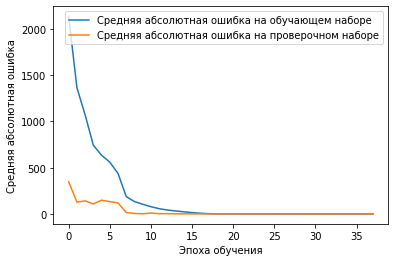

In [36]:
# Обучение модели на простых данных

model_simple = Sequential()
#model_simple.add(BatchNormalization(input_dim=x_train_r.shape[1]))
#model_simple.add(Dense(128, activation='relu'))
#model_simple.add(Dense(1000, activation='tanh'))
#model_simple.add(Dense(100, activation='relu'))
#model_simple.add(Dense(1, activation='linear'))

model_simple.add(Dense(1000, input_dim=x_train_r.shape[1]))
model_simple.add(Dropout(0.2))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

#history = model_simple.fit(x_train_r, 
#                    y_train_r, 
#                    epochs=50, 
#                    batch_size=256,
#                    validation_split=0.15, 
#                    verbose=1)

# 50000 примеров будет в обучающей выборке
n_val = 50000

history = model_simple.fit(x_train_r[:n_val],
                              y_train_r[:n_val],
                              batch_size=32, 
                              epochs=100, 
                              validation_data=(x_train_r[n_val:], y_train_r[n_val:]), 
                              verbose=1, 
                              callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history)

In [37]:
# Сравнивает отскейленные данные

def total_MAE_predict(model,x_test, y_test):
  
  # Инициализируем начальное значение ошибки
  mae = 0 
  y_pred = model.predict(x_test)
  y_pred_unscaled = y_scaler.inverse_transform(y_pred).flatten()

  # Считаем среднюю цену, среднюю ошибку и средний процент ошибки
  mean_delta = np.mean(abs(y_pred_unscaled - y_test))
  mean_price = np.mean(y_test)
  
  print('Средняя ошибка: ', round(mean_delta))
  print('Средняя цена: ', round(mean_price))
  print('Суммарный процент ошибки: ', round(100*mean_delta/mean_price), '%', sep='')

In [38]:
total_MAE_predict(model_simple, x_test_r, y_test_r)

157/157 [==============================] - 0s 2ms/step
Средняя ошибка:  338614
Средняя цена:  521242
Суммарный процент ошибки: 65%


In [39]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 10000000.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred).flatten()

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: ',y_train[i], ' Предсказанное значение: ',pred[i], ' Разница: ', abs(y_train[i] - pred[i]))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()        

157/157 [==============================] - 0s 2ms/step
Средняя абсолютная ошибка: 301642.3271296875 

Реальное значение:  [996000]  Предсказанное значение:  525625.94  Разница:  [470374.0625]
Реальное значение:  [140200]  Предсказанное значение:  508602.7  Разница:  [368402.6875]
Реальное значение:  [750000]  Предсказанное значение:  525102.9  Разница:  [224897.125]
Реальное значение:  [970000]  Предсказанное значение:  514364.72  Разница:  [455635.28125]
Реальное значение:  [205000]  Предсказанное значение:  460965.12  Разница:  [255965.125]
Реальное значение:  [985000]  Предсказанное значение:  522449.44  Разница:  [462550.5625]
Реальное значение:  [589000]  Предсказанное значение:  488960.66  Разница:  [100039.34375]
Реальное значение:  [500000]  Предсказанное значение:  466435.8  Разница:  [33564.1875]
Реальное значение:  [1320000]  Предсказанное значение:  497806.22  Разница:  [822193.78125]
Реальное значение:  [270000]  Предсказанное значение:  383146.75  Разница:  [113146.75]


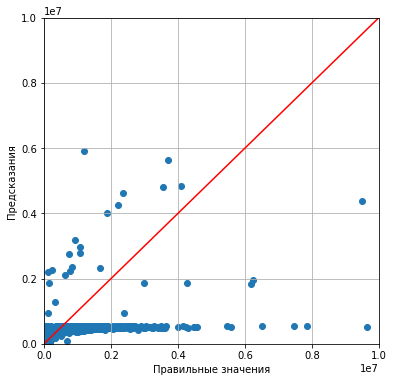

In [40]:
eval_net(model_simple, x_test_r, y_test_r,y_scaler=y_scaler)

##Подотовка текстовых данных "model"


In [41]:
model_text = df.model

In [42]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

tokenizer.fit_on_texts(model_text) 

In [43]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('поколение', 2), ('рестайлинг', 3), ('1', 4), ('2', 5), ('3', 6), ('класс', 7), ('5', 8), ('серия', 9), ('focus', 10), ('astra', 11), ('nexia', 12), ('й', 13), ('4', 14), ('6', 15), ('octavia', 16), ('rio', 17), ('e', 18), ('lancer', 19), ('solaris', 20), ('logan', 21), ('h', 22), ('matiz', 23), ('passat', 24), ('7', 25), ('m150', 26), ('c', 27), ('niva', 28), ('family', 29), ('a6', 30), ('x', 31), ('a4', 32), ('200', 33), ('polo', 34), ('pajero', 35), ('cx', 36), ('cruze', 37), ('grand', 38), ('j300', 39), ('ix', 40), ('sportage', 41), ('s', 42), ('lacetti', 43), ('corolla', 44), ('duster', 45), ('x5', 46), ('outlander', 47), ('a', 48), ('308', 49), ('b3', 50)]
Размер словаря 1454


In [44]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
model_seq = tokenizer.texts_to_sequences(model_text)

**Создание обучающей и проверочной выборок**


In [45]:
# Преобразование последовательностей индексов в bag of words
x_train_model = tokenizer.sequences_to_matrix(model_seq)
x_train_model_r = x_train_model[5000:]
x_test_model_r = x_train_model[:5000]

In [46]:
# Проверка результата
print(x_train_model_r.shape)
print(x_test_model_r.shape)

(65113, 3000)
(5000, 3000)


In [47]:
# Проверка получившихся данных
n = 1
print(model_text[n])                       # model в тексте
print(model_seq[n])                        # model в индексах слов
print(x_train_model_r[n][0:100])          # model в bag of words

nexia 1 поколение [2-й рестайлинг]
[12, 4, 2, 5, 13, 3]
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [48]:
# Освобождение памяти от ненужных более объектов
del model_text, model_seq, tokenizer

**Обучение модели на простых текстовых данных**


Epoch 1/50
217/217 [==============================] - 2s 10ms/step - loss: 0.9756 - mae: 0.5569 - val_loss: 1.1622 - val_mae: 0.5637
Epoch 2/50
217/217 [==============================] - 2s 10ms/step - loss: 0.9723 - mae: 0.5534 - val_loss: 1.1591 - val_mae: 0.5613
Epoch 3/50
217/217 [==============================] - 2s 10ms/step - loss: 0.9687 - mae: 0.5512 - val_loss: 1.1553 - val_mae: 0.5592
Epoch 4/50
217/217 [==============================] - 2s 10ms/step - loss: 0.9644 - mae: 0.5494 - val_loss: 1.1505 - val_mae: 0.5569
Epoch 5/50
217/217 [==============================] - 2s 9ms/step - loss: 0.9592 - mae: 0.5465 - val_loss: 1.1449 - val_mae: 0.5555
Epoch 6/50
217/217 [==============================] - 2s 9ms/step - loss: 0.9533 - mae: 0.5446 - val_loss: 1.1385 - val_mae: 0.5530
Epoch 7/50
217/217 [==============================] - 2s 11ms/step - loss: 0.9466 - mae: 0.5422 - val_loss: 1.1312 - val_mae: 0.5499
Epoch 8/50
217/217 [==============================] - 2s 10ms/step - lo

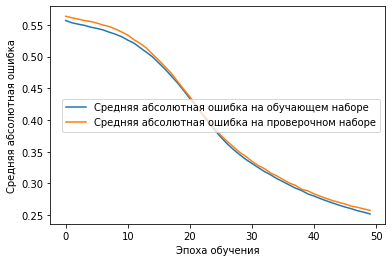

In [49]:
# Обучение модели на данных о профессии

model_model = Sequential()
model_model.add(Dense(20, activation='relu', input_dim=x_train_model_r.shape[1]))
model_model.add(Dense(500, activation='relu'))
model_model.add(Dense(1, activation='linear'))

model_model.compile(optimizer=Adagrad(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_model.fit(x_train_model_r, 
                    y_train_r, 
                    batch_size=256,
                    epochs=50, 
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

In [50]:
total_MAE_predict(model_model, x_test_model_r, y_test_r)

157/157 [==============================] - 0s 2ms/step
Средняя ошибка:  447058
Средняя цена:  521242
Суммарный процент ошибки: 86%


157/157 [==============================] - 0s 3ms/step
Средняя абсолютная ошибка: 152072.0770904297 

Реальное значение:  [996000]  Предсказанное значение:  530347.8  Разница:  [465652.1875]
Реальное значение:  [140200]  Предсказанное значение:  152129.03  Разница:  [11929.03125]
Реальное значение:  [750000]  Предсказанное значение:  641305.94  Разница:  [108694.0625]
Реальное значение:  [970000]  Предсказанное значение:  955376.8  Разница:  [14623.1875]
Реальное значение:  [205000]  Предсказанное значение:  253067.9  Разница:  [48067.90625]
Реальное значение:  [985000]  Предсказанное значение:  759601.06  Разница:  [225398.9375]
Реальное значение:  [589000]  Предсказанное значение:  656622.9  Разница:  [67622.875]
Реальное значение:  [500000]  Предсказанное значение:  455952.1  Разница:  [44047.90625]
Реальное значение:  [1320000]  Предсказанное значение:  821537.06  Разница:  [498462.9375]
Реальное значение:  [270000]  Предсказанное значение:  288221.1  Разница:  [18221.09375]


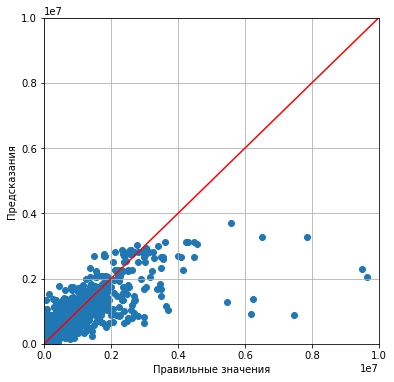

In [51]:
eval_net(model_model, x_test_model_r, y_test_r,y_scaler=y_scaler)

##Обучение нейронной сети класса Model

In [52]:
input1 = Input((x_train_r.shape[1],))
input2 = Input((x_train_model_r.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2), x)

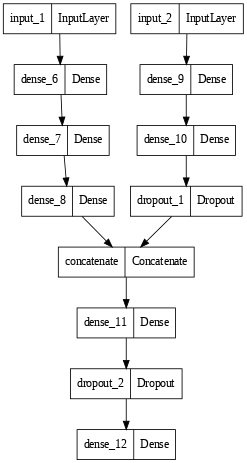

In [53]:
utils.plot_model(model_final, dpi=60)

In [54]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([x_train_r, x_train_model_r], 
                           y_train_scaled,
                           batch_size=256, 
                           epochs=50, 
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
217/217 [==============================] - 7s 27ms/step - loss: 0.9773 - mae: 0.5582 - val_loss: 1.1797 - val_mae: 0.5498
Epoch 2/50
217/217 [==============================] - 6s 29ms/step - loss: 0.9731 - mae: 0.5547 - val_loss: 1.1796 - val_mae: 0.5517
Epoch 3/50
217/217 [==============================] - 5s 24ms/step - loss: 0.9731 - mae: 0.5559 - val_loss: 1.1796 - val_mae: 0.5512
Epoch 4/50
217/217 [==============================] - 5s 24ms/step - loss: 0.9731 - mae: 0.5556 - val_loss: 1.1796 - val_mae: 0.5515
Epoch 5/50
217/217 [==============================] - 6s 27ms/step - loss: 0.9731 - mae: 0.5548 - val_loss: 1.1796 - val_mae: 0.5513
Epoch 6/50
217/217 [==============================] - 6s 26ms/step - loss: 0.9731 - mae: 0.5557 - val_loss: 1.1796 - val_mae: 0.5517
Epoch 7/50
217/217 [==============================] - 5s 23ms/step - loss: 0.9731 - mae: 0.5557 - val_loss: 1.1796 - val_mae: 0.5511
Epoch 8/50
217/217 [==============================] - 5s 23ms/step - 

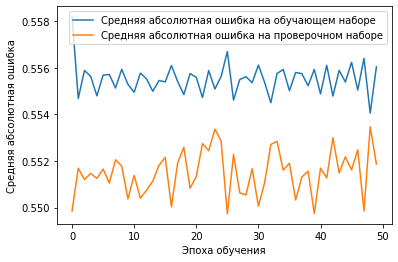

In [55]:
plot_history(history)

157/157 [==============================] - 1s 3ms/step
Средняя абсолютная ошибка: 340442.13 

Реальное значение:  [996000]  Предсказанное значение:  527209.75  Разница:  [468790.25]
Реальное значение:  [140200]  Предсказанное значение:  527209.75  Разница:  [387009.75]
Реальное значение:  [750000]  Предсказанное значение:  527209.75  Разница:  [222790.25]
Реальное значение:  [970000]  Предсказанное значение:  527209.75  Разница:  [442790.25]
Реальное значение:  [205000]  Предсказанное значение:  527209.75  Разница:  [322209.75]
Реальное значение:  [985000]  Предсказанное значение:  527209.75  Разница:  [457790.25]
Реальное значение:  [589000]  Предсказанное значение:  527209.75  Разница:  [61790.25]
Реальное значение:  [500000]  Предсказанное значение:  527209.75  Разница:  [27209.75]
Реальное значение:  [1320000]  Предсказанное значение:  527209.75  Разница:  [792790.25]
Реальное значение:  [270000]  Предсказанное значение:  527209.75  Разница:  [257209.75]


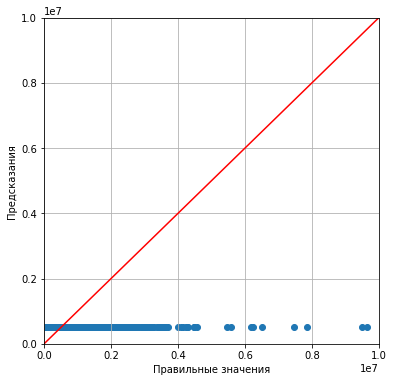

In [56]:
eval_net(model_final, [x_test_r, x_test_model_r], y_test_r, y_scaler)

In [57]:
total_MAE_predict(model_final, [x_test_r, x_test_model_r], y_test_r)

157/157 [==============================] - 0s 3ms/step
Средняя ошибка:  340442
Средняя цена:  521242
Суммарный процент ошибки: 65%
